In [31]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [32]:
raw_train_df = pd.read_csv("./data/train.csv")
raw_test_df = pd.read_csv("./data/test.csv")

In [33]:
def text_cleaner(text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text

In [34]:
del raw_train_df['keyword']
del raw_train_df['location']

In [35]:
# Replaces the null values in the data with an empty string
train_data = raw_train_df.where((pd.notnull(raw_train_df)),'')
test_data = raw_test_df.where((pd.notnull(raw_test_df)),'')

train_data['text'] = text_cleaner(train_data['text'])
test_data['text'] = text_cleaner(test_data['text'])

C:\Users\GHOSH\AppData\Local\Temp\ipykernel_32464\3041639151.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"\#","") # replaces hashtags
C:\Users\GHOSH\AppData\Local\Temp\ipykernel_32464\3041639151.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"http\S+","URL")  # remove URL addresses
C:\Users\GHOSH\AppData\Local\Temp\ipykernel_32464\3041639151.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
C:\Users\GHOSH\AppData\Local\Temp\ipykernel_32464\3041639151.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  text = text.str.replace("\s{2,}", " ")


In [36]:
X, Y = train_data['text'], train_data['target']

In [37]:
feature_extraction = TfidfVectorizer(min_df = 1, stop_words='english', lowercase='True')

# Below we fit the vectorizer to the training data 
X_train_features = feature_extraction.fit_transform(X_train)
# not need to fit this time only transform based on the previous fit
X_test_features = feature_extraction.transform(X_test)

# convert all values of Y_train and Y_test to integers 
Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 3)

print(X_train.shape, X_test.shape)

(6090,) (1523,)


In [39]:
class NeuralNet(nn.Module):
    def __init__(self, input_dims, hidden_dims_1, hidden_dims_2):
        super(NeuralNet, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims_1)
        self.linear2 = nn.Linear(hidden_dims_1, hidden_dims_2)
        self.linear3 = nn.Linear(hidden_dims_2, 1)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x

In [40]:
print(X_train_features.toarray().shape)

sc = StandardScaler()
X_train_fit = sc.fit_transform(X_train_features.toarray())
X_test_fit = sc.transform(X_test_features.toarray())

#scale
X_train_tensor = torch.from_numpy(X_train_fit.astype(np.float32))
X_test_tensor = torch.from_numpy(X_test_fit.astype(np.float32))
Y_train_tensor = torch.from_numpy(Y_train.to_numpy().astype(np.float32))
Y_test_tensor = torch.from_numpy(Y_test.to_numpy().astype(np.float32))

# # converts the tensor from 1 row to n rows with one column each
Y_train_tensor = Y_train_tensor.view(Y_train_tensor.shape[0],1)
Y_test_tensor = Y_test_tensor.view(Y_test_tensor.shape[0],1)

(6090, 14504)


In [45]:
model = NeuralNet(X_train_features.shape[1],1000,10)
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [60]:
n_epochs = 9
all_losses = []
for epoch in range(n_epochs):
    Y_pred = model(X_train_tensor)
    
    loss = criterion(Y_pred, Y_train_tensor)
    all_losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f'epoch: {epoch+1}, loss = {loss.item():.4f}, learning rate = {learning_rate:2f}')
    if loss < 0.12:
        

epoch: 1, loss = 0.1157, learning rate = 0.001000


KeyboardInterrupt: 

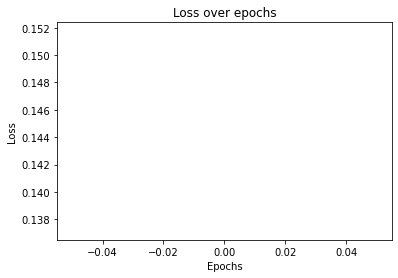

In [56]:
plt.figure()
plt.title("Loss over epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(all_losses)
plt.show()

In [61]:
with torch.no_grad():
    Y_pred = model(X_test_tensor)
    Y_pred_cls = Y_pred.round()
    acc = Y_pred_cls.eq(Y_test_tensor).sum() / float(Y_test_tensor.shape[0])
    print(f'accuracy= {acc:.4f}')

accuracy= 0.7531
